In [1]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap

In [8]:
from pandas.util._exceptions import find_stack_level

In [3]:
sc.settings.n_jobs = 96
sc.set_figure_params(figsize=(4, 4), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# Basic Processing

In [ ]:
adata = sc.read_h5ad("Data/Output_230807_subset.NeuralCrest_finalmeta_SYK.h5ad") # 2m

In [ ]:
adata

AnnData object with n_obs × n_vars = 276111 × 49133
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cluster_number', 'cluster_raw', 'layer', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6'
    uns: 'cluster_main_colors', 'log1p'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts', 'logcounts'

In [ ]:
adata_scaled = sc.read_h5ad("Data/Output_230807_subset.NeuralCrest_scaled_SYK.h5ad")

In [8]:
adata_scaled

AnnData object with n_obs × n_vars = 276111 × 49133
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling'
    var: 'mean', 'std'
    uns: 'log1p'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'scaled'

In [9]:
adata.layers["scaled"] = adata_scaled.layers["scaled"].copy()

In [10]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [11]:
adata.obs['Stage2'] = 'Unknown'
# Set the value of 'Stage2' to 'First trimester' if 'Age' is between 7 and 30
adata.obs.loc[(adata.obs['Age'] <= 7 * 14), 'Stage2'] = 'Fetal (1st trimester)'
adata.obs.loc[(adata.obs['Age'] > 7 * 14) & (adata.obs['Age'] <= 7 * 24), 'Stage2'] = 'Fetal (2nd trimester)'
adata.obs.loc[(adata.obs['Age'] > 7 * 24) & (adata.obs['Age'] <= 365), 'Stage2'] = 'Fetal (3rd trimester)'
adata.obs.loc[(adata.obs['Age'] > 365) & (adata.obs['Age'] <= 545), 'Stage2'] = 'Neonatal'
adata.obs.loc[(adata.obs['Age'] > 545) & (adata.obs['Age'] <= 2555), 'Stage2'] = 'Childhood (1-6Y)'
adata.obs.loc[(adata.obs['Age'] > 2555) & (adata.obs['Age'] <= 4745), 'Stage2'] = 'Childhood (6-12Y)'
adata.obs.loc[(adata.obs['Age'] > 4745) & (adata.obs['Age'] <= 7665), 'Stage2'] = 'Adolescence (12-20Y)'
adata.obs.loc[(adata.obs['Age'] >= 7665) & (adata.obs['Age'] <= 14965), 'Stage2'] = 'Adult (20-40Y)'
adata.obs.loc[(adata.obs['Age'] > 14965) & (adata.obs['Age'] <= 22265), 'Stage2'] = 'Adult (40-60Y)'
adata.obs.loc[(adata.obs['Age'] > 22265) & (adata.obs['Age'] <= 29565), 'Stage2'] = 'Adult (60-80Y)'
adata.obs.loc[(adata.obs['Age'] > 29565), 'Stage2'] = 'Adult (>80Y)'

In [12]:
adata.obs['Stage2'] = adata.obs['Stage2'].astype('category')
adata.obs['Stage2'].cat.reorder_categories(['Fetal (1st trimester)', 'Fetal (2nd trimester)', 'Neonatal', 'Adult (20-40Y)', 'Adult (40-60Y)', 'Adult (60-80Y)', 'Adult (>80Y)'], inplace=True)

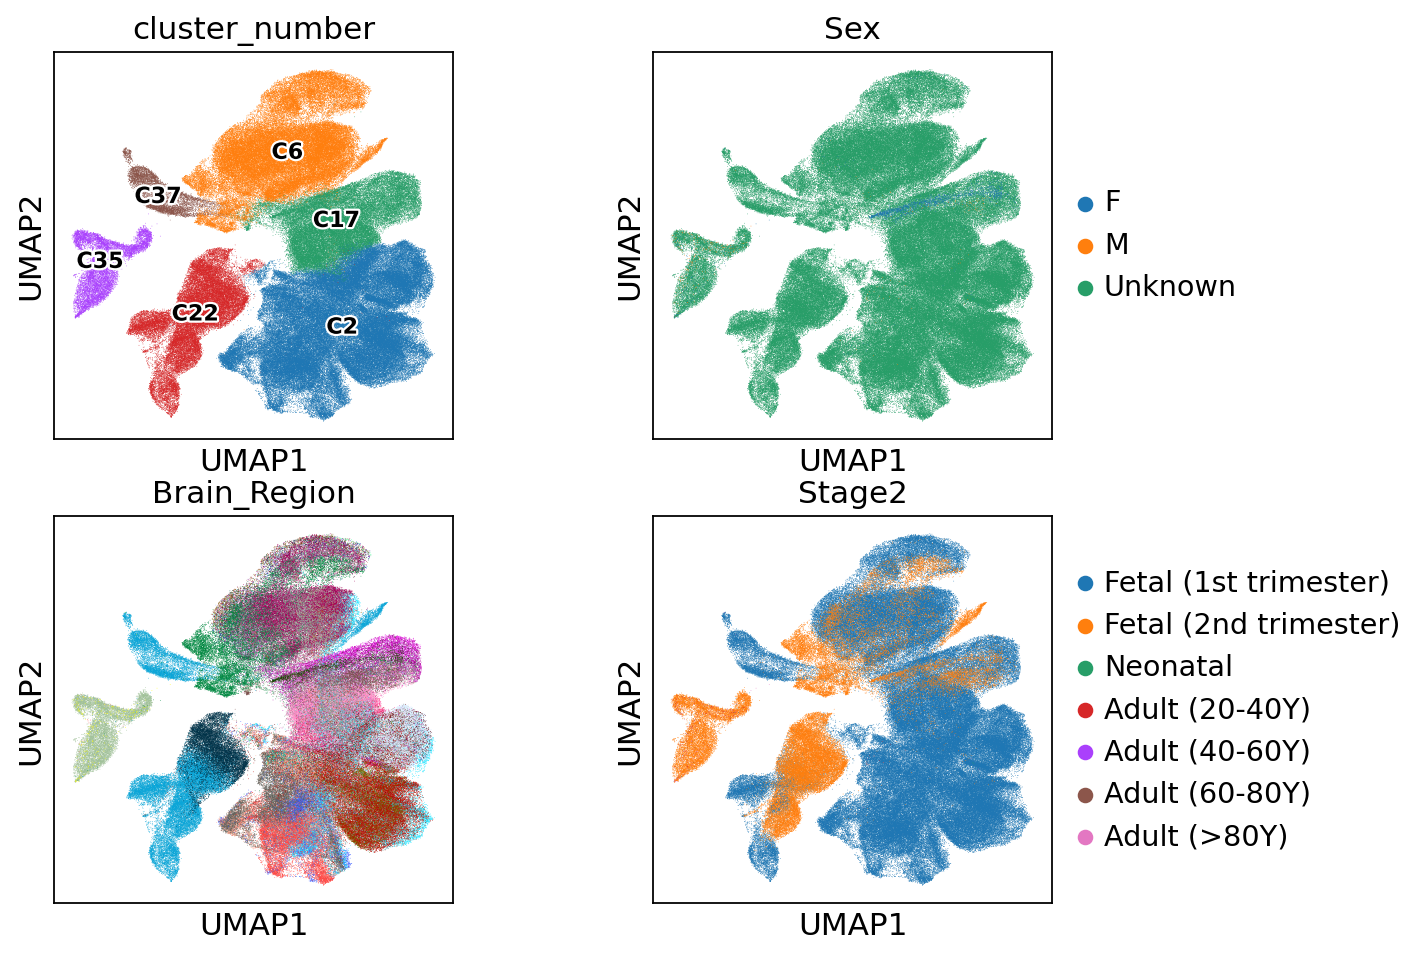

In [13]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,7), gridspec_kw={'wspace':0.5})

ax1_dict = sc.pl.umap(adata, color = "cluster_number", ax = ax1, legend_loc='on data', legend_fontsize=10, legend_fontoutline=2, show = False)
ax2_dict = sc.pl.umap(adata, color = "Sex", ax = ax2, show = False)
ax3_dict = sc.pl.umap(adata, color = "Brain_Region", ax = ax3, show = False, legend_loc = None)
ax4_dict = sc.pl.umap(adata, color = "Stage2", ax = ax4, show = False)

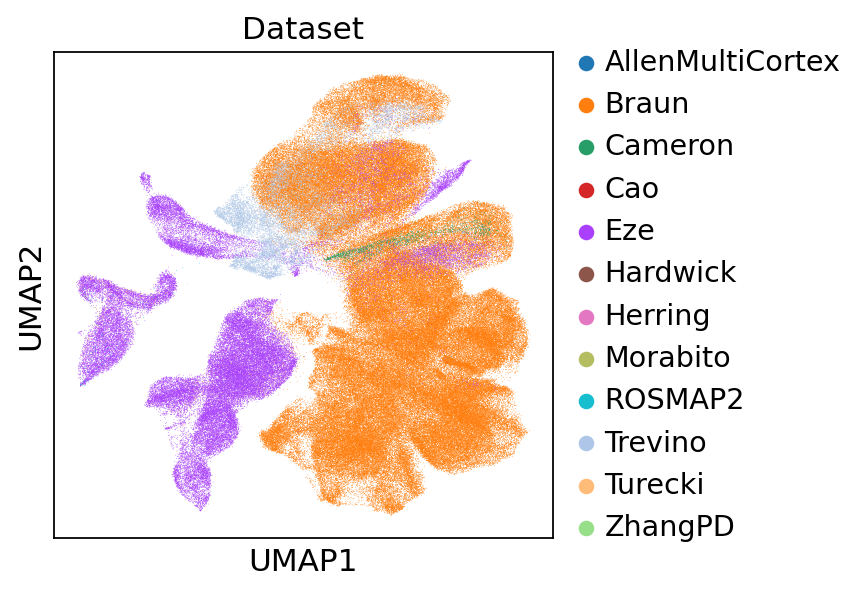

In [14]:
sc.pl.umap(adata, color = 'Dataset')

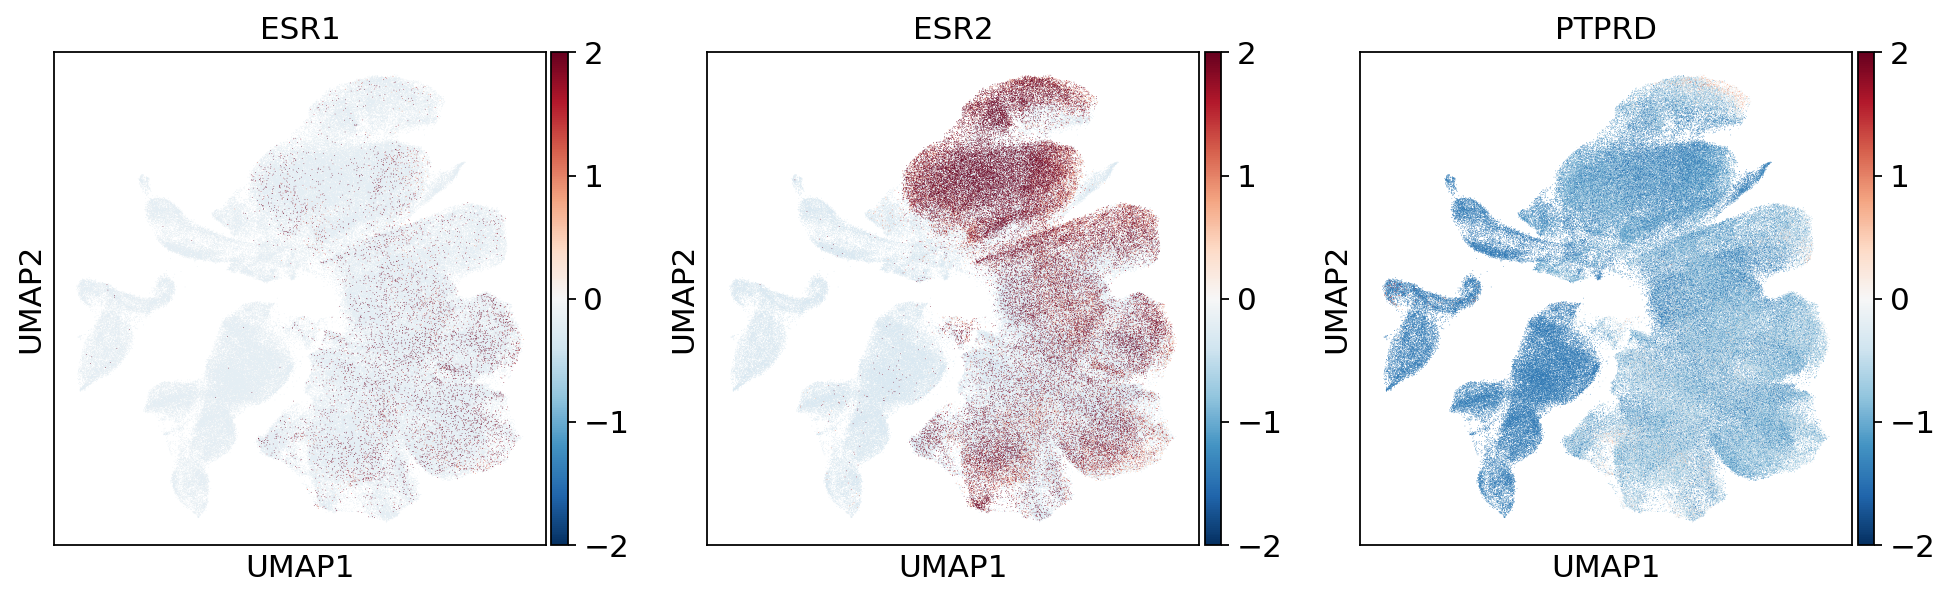

In [15]:
marker_genes = ['ESR1', 'ESR2', 'PTPRD']
sc.set_figure_params(figsize=(4, 4), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

sc.pl.umap(adata, color = marker_genes, cmap='RdBu_r', layer = "scaled", vmin = -2, vmax = 2, 
          legend_loc='on data', legend_fontsize=5)

In [16]:
adata.write_h5ad("Data/Output_230810_subset.NeuralCrest_processed_SYK.h5ad")

# Automatic annotation of neural crest cells

In [4]:
adata = sc.read_h5ad("Data/Output_230810_subset.NeuralCrest_processed_SYK.h5ad")

In [5]:
import celltypist
from celltypist import models

In [6]:
adata.shape

(276111, 49133)

## Assign cell type labels

In [7]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 19
📂 Storing models in /home/ssun1116/.celltypist/data/models
💾 Downloading model [1/19]: Immune_All_Low.pkl
💾 Downloading model [2/19]: Immune_All_High.pkl
💾 Downloading model [3/19]: Adult_Mouse_Gut.pkl
💾 Downloading model [4/19]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [5/19]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [6/19]: COVID19_Immune_Landscape.pkl
💾 Downloading model [7/19]: Cells_Fetal_Lung.pkl
💾 Downloading model [8/19]: Cells_Intestinal_Tract.pkl
💾 Downloading model [9/19]: Cells_Lung_Airway.pkl
💾 Downloading model [10/19]: Developing_Human_Brain.pkl
💾 Downloading model [11/19]: Developing_Human_Thymus.pkl
💾 Downloading model [12/19]: Developing_Mouse_Brain.pkl
💾 Downloading model [13/19]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [14/19]: Human_IPF_Lung.pkl
💾 Downloading model [15/19]: Human_Lung_Atlas.pkl
💾 Downloading model [16/19]: Human

In [25]:
model = models.Model.load(model = "Developing_Human_Brain.pkl")

In [26]:
model

CellTypist model with 129 cell types and 1000 features
    date: 2022-10-29 21:02:53.713593
    details: cell types from the first-trimester developing human brain
    source: https://doi.org/10.1101/2022.10.24.513487
    version: v1
    cell types: Brain erythrocytes, Brain fibroblasts, ..., Ventral midbrain radial glia
    features: VWA1, HES5, ..., BGN

In [27]:
model.cell_types

array(['Brain erythrocytes', 'Brain fibroblasts', 'Brain immune cells',
       'Brain neuroblast', 'Brain neuron', 'Brain neuronal IPC',
       'Brain placode cells', 'Brain radial glia', 'Brain vascular cells',
       'Cerebellum glioblast', 'Cerebellum immune cells',
       'Cerebellum neural crest cells', 'Cerebellum neuroblast',
       'Cerebellum neuron', 'Cerebellum neuronal IPC', 'Cerebellum OPC',
       'Cerebellum radial glia', 'Cortex glioblast',
       'Cortex immune cells', 'Cortex neuroblast', 'Cortex neuron',
       'Cortex neuronal IPC', 'Cortex OPC', 'Cortex radial glia',
       'Diencephalon glioblast', 'Diencephalon immune cells',
       'Diencephalon neuroblast', 'Diencephalon neuron',
       'Diencephalon neuronal IPC', 'Diencephalon radial glia',
       'Dorsal midbrain glioblast', 'Dorsal midbrain immune cells',
       'Dorsal midbrain neuroblast', 'Dorsal midbrain neuron',
       'Dorsal midbrain neuronal IPC', 'Dorsal midbrain OPC',
       'Dorsal midbrain radia

In [40]:
model.features

array(['VWA1', 'HES5', 'TP73', 'SLC2A5', 'C1orf127', 'TNFRSF1B', 'KAZN',
       'SRARP', 'CDA', 'ALPL', 'WNT4', 'C1QA', 'C1QC', 'C1QB', 'ID3',
       'NCMAP', 'RUNX3', 'OPRD1', 'MATN1', 'LAPTM5', 'GJA4', 'CSF3R',
       'HEYL', 'MFSD2A', 'SLC2A1', 'FAM183A', 'TIE1', 'RNF220', 'DMBX1',
       'AGBL4', 'TTC22', 'DAB1', 'NFIA', 'ROR1', 'TCTEX1D1', 'LRRC7',
       'NEGR1', 'ADGRL4', 'CCN1', 'BRDT', 'ARHGAP29', 'DPYD', 'CSF1',
       'CD53', 'PIFO', 'TAFA3', 'OLFML3', 'SPAG17', 'TBX15', 'HJV',
       'FCGR1A', 'C1orf54', 'ECM1', 'CTSS', 'S100A10', 'S100A11',
       'S100A9', 'S100A8', 'S100A4', 'S100A16', 'S100A1', 'BCAN', 'ETV3L',
       'CD5L', 'SPTA1', 'MNDA', 'ATP1A2', 'FCER1G', 'MPZ', 'FCGR2A',
       'HSPA6', 'RGS5', 'LMX1A', 'DPT', 'SELL', 'SELE', 'PRRX1', 'TNR',
       'CACNA1E', 'RGS16', 'NPL', 'HMCN1', 'BRINP3', 'RGS18', 'RGS1',
       'CFH', 'LHX9', 'PTPRC', 'CHIT1', 'PRELP', 'KISS1', 'CNTN2',
       'SLC26A9', 'CD34', 'G0S2', 'ESRRG', 'AGT', 'DISC1', 'SLC35F3',
       'NID1', 'R

# Perform predictions

In [9]:
adata.X = adata.layers["counts"].copy()

In [10]:
np.max(adata.X)

12825.0

In [11]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [12]:
np.max(adata.X)

8.446086

In [13]:
predictions = celltypist.annotate(adata, model = 'Developing_Human_Brain.pkl', majority_voting = True, )

🔬 Input data has 276111 cells and 49133 genes
🔗 Matching reference genes in the model
🧬 968 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 30
🗳️ Majority voting the predictions
✅ Majority voting done!


In [14]:
predictions

CellTypist prediction result for 276111 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 276111 query cells and 129 cell types
    probability_matrix: data frame with 276111 query cells and 129 cell types
    adata: AnnData object referred

In [15]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

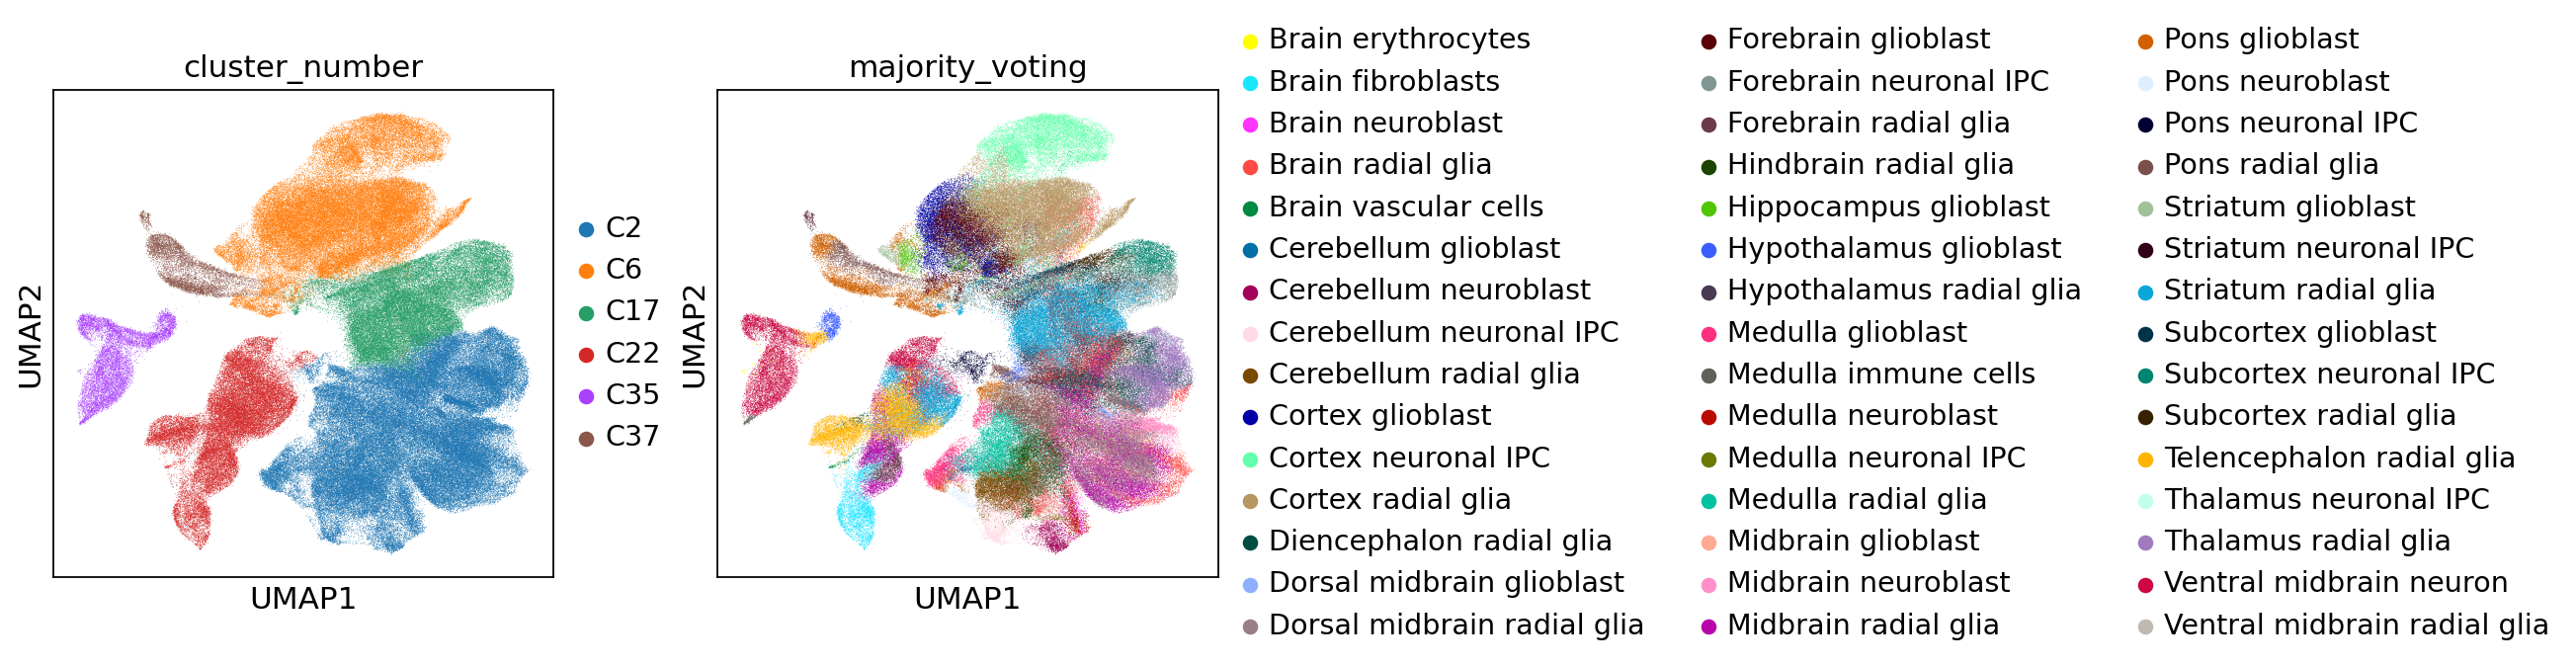

In [20]:
sc.pl.umap(adata, color = ['cluster_number', 'majority_voting'])

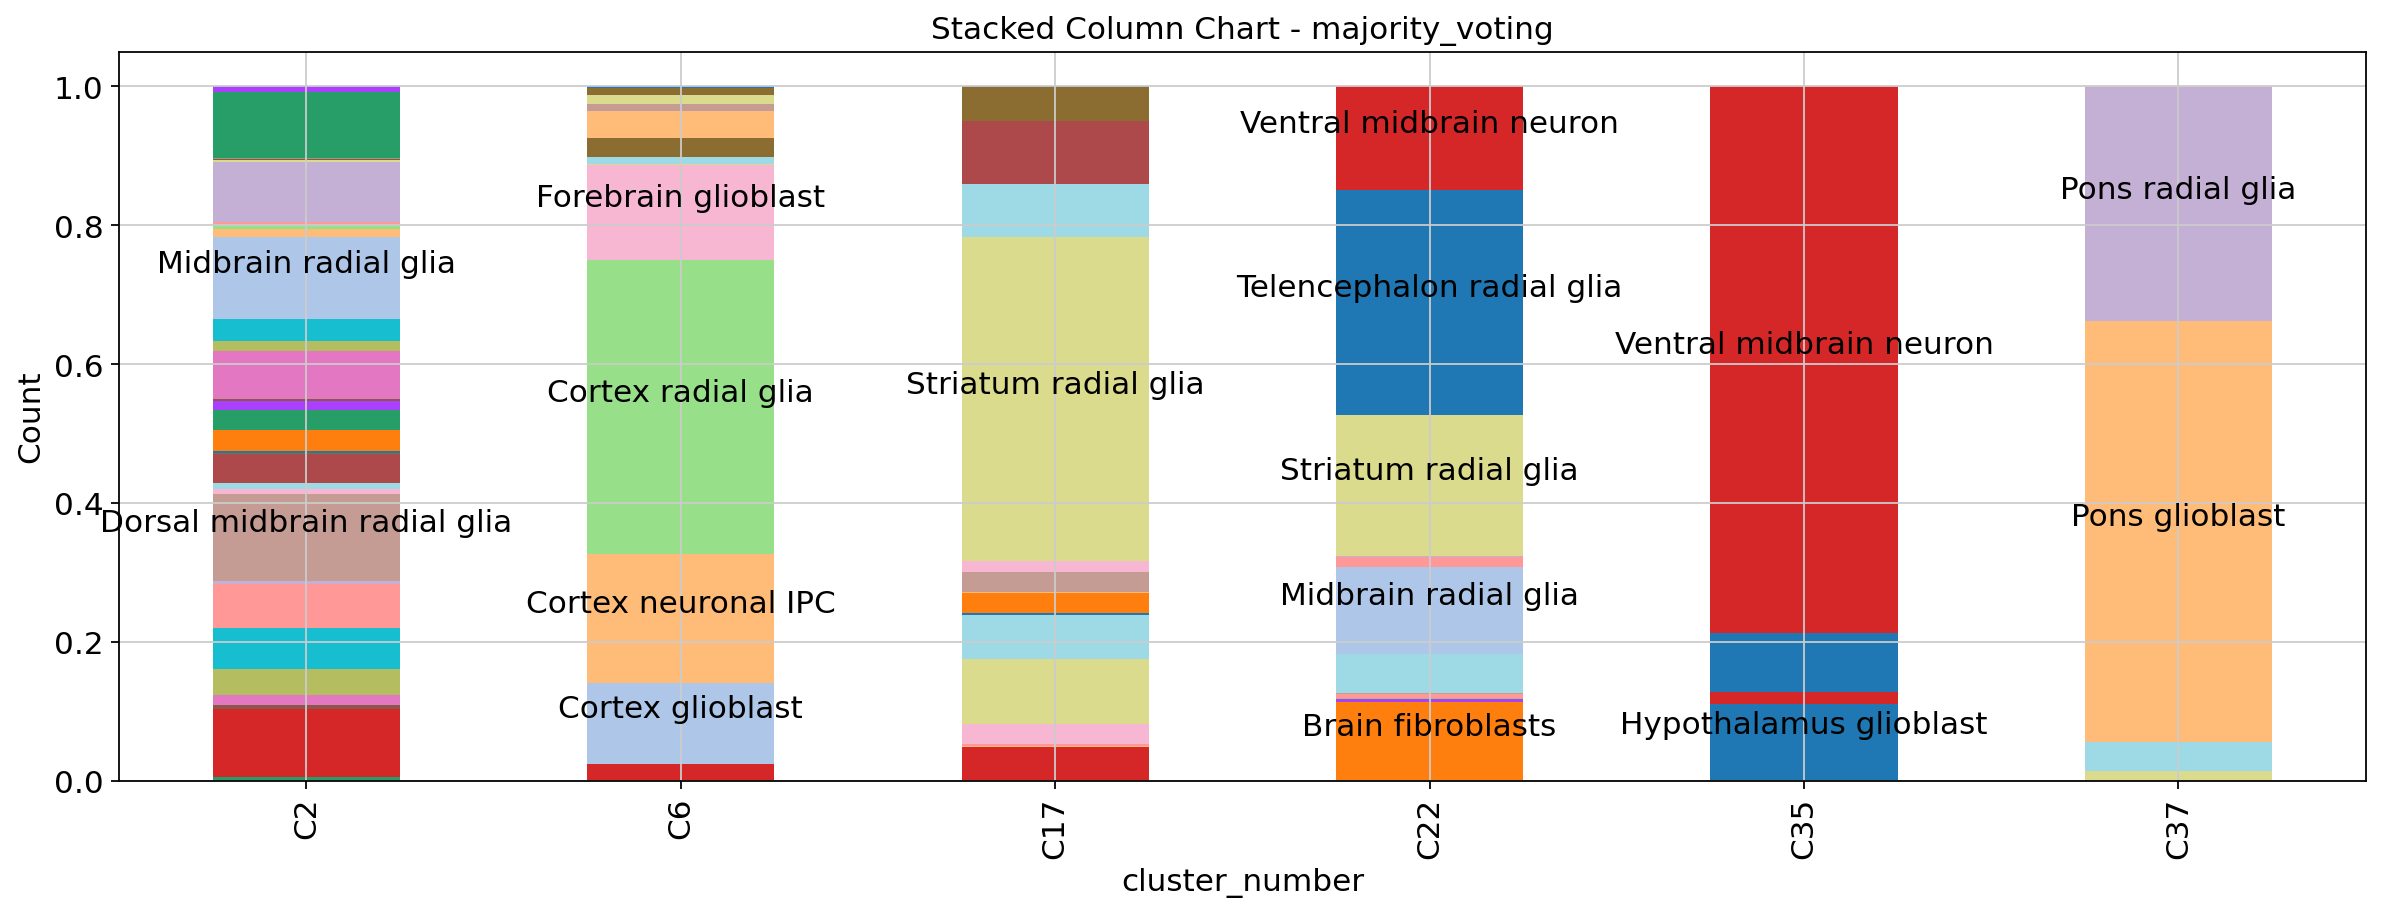

In [23]:
import matplotlib.pyplot as plt
df1 = adata.obs[['majority_voting', 'cluster_number']]

# Iterate over the columns and create individual stacked column charts
for column in df1.columns[:-1]:  # Exclude the 'cluster_number' column

    # Calculate the count of each unique value in the 'cluster_number' column
    grouped = df1.groupby(['cluster_number', column]).size().reset_index(name='count')

    # Pivot the DataFrame to have the 'cluster_number' column as the index and other columns as columns
    pivot_df = grouped.pivot(index='cluster_number', columns=column, values='count').fillna(0)

    # Calculate the percentage of each category within each 'cluster_number' group
    stacked_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    # Plotting the stacked column chart
    ax = stacked_df.plot(kind='bar', stacked=True, figsize=(18, 6))

    # Set the title and axis labels
    plt.title(f"Stacked Column Chart - {column}")
    plt.xlabel('cluster_number')
    plt.ylabel('Count')

    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., ncol=2)

    # Add text labels on the stacked bars reflecting the bar group names
    for container, category in zip(ax.containers, stacked_df.columns):
        for rect in container.patches:
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            label = category if rect.get_height() >= 0.1 else ""  # Use the category name as the label if the proportion exceeds 0.1
            ax.text(x, y, label, ha='center', va='bottom')

    # Remove the legend
    ax.legend().remove()

    # Display the chart
    plt.show()


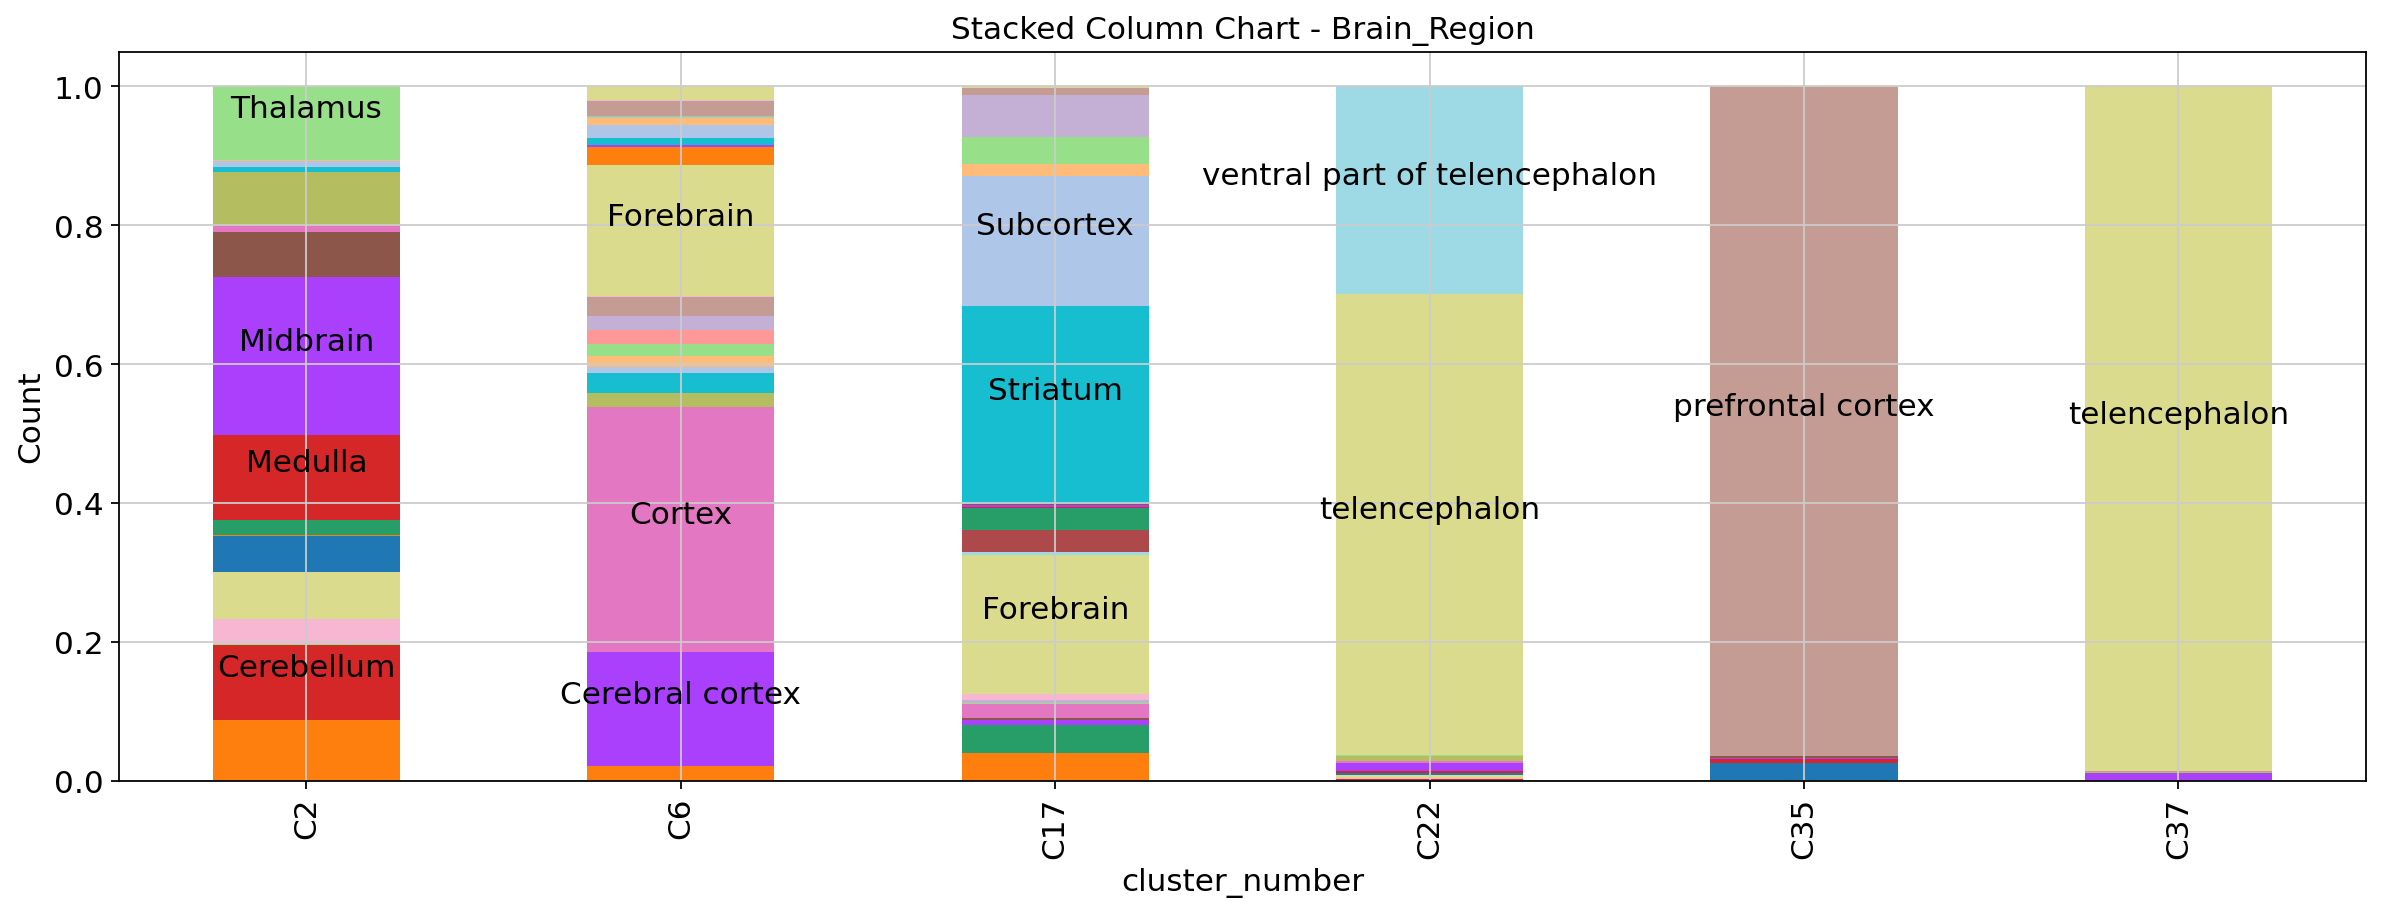

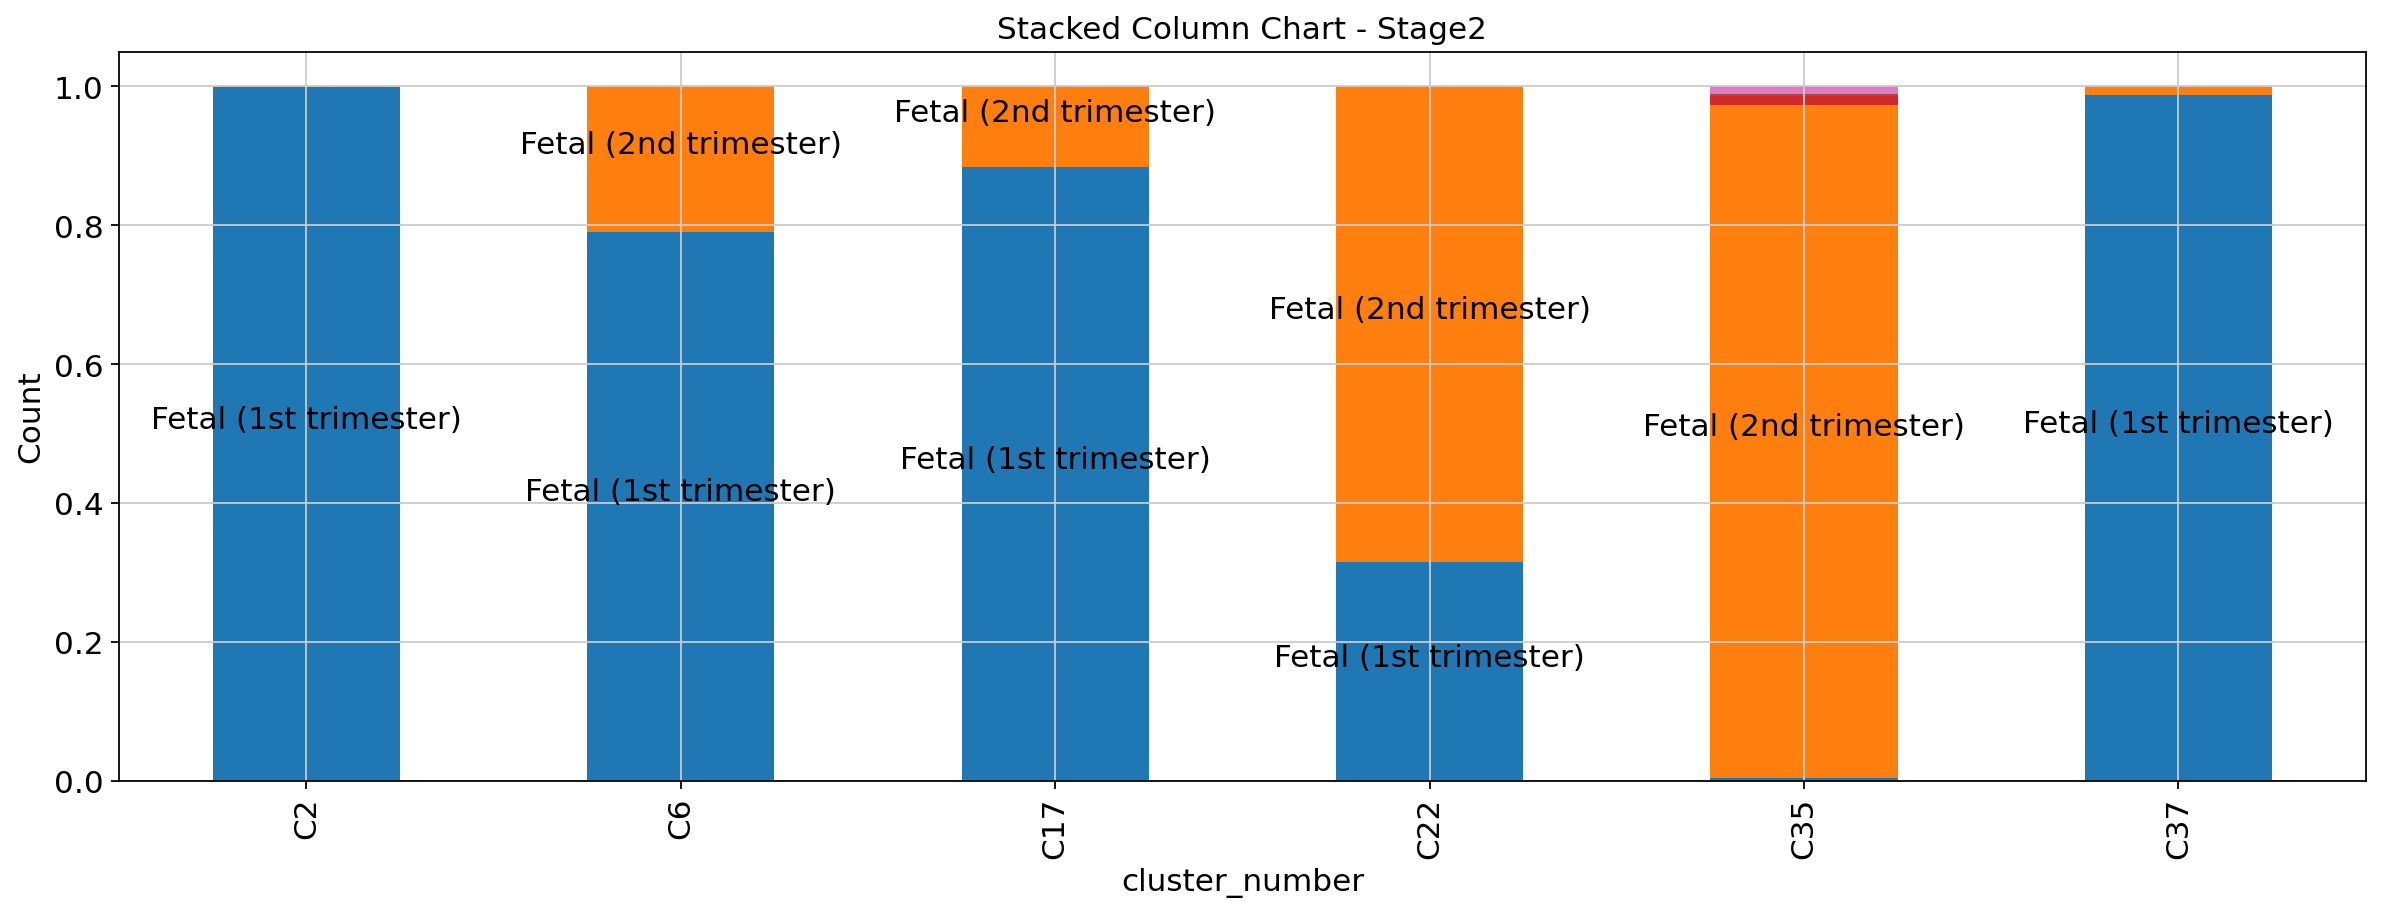

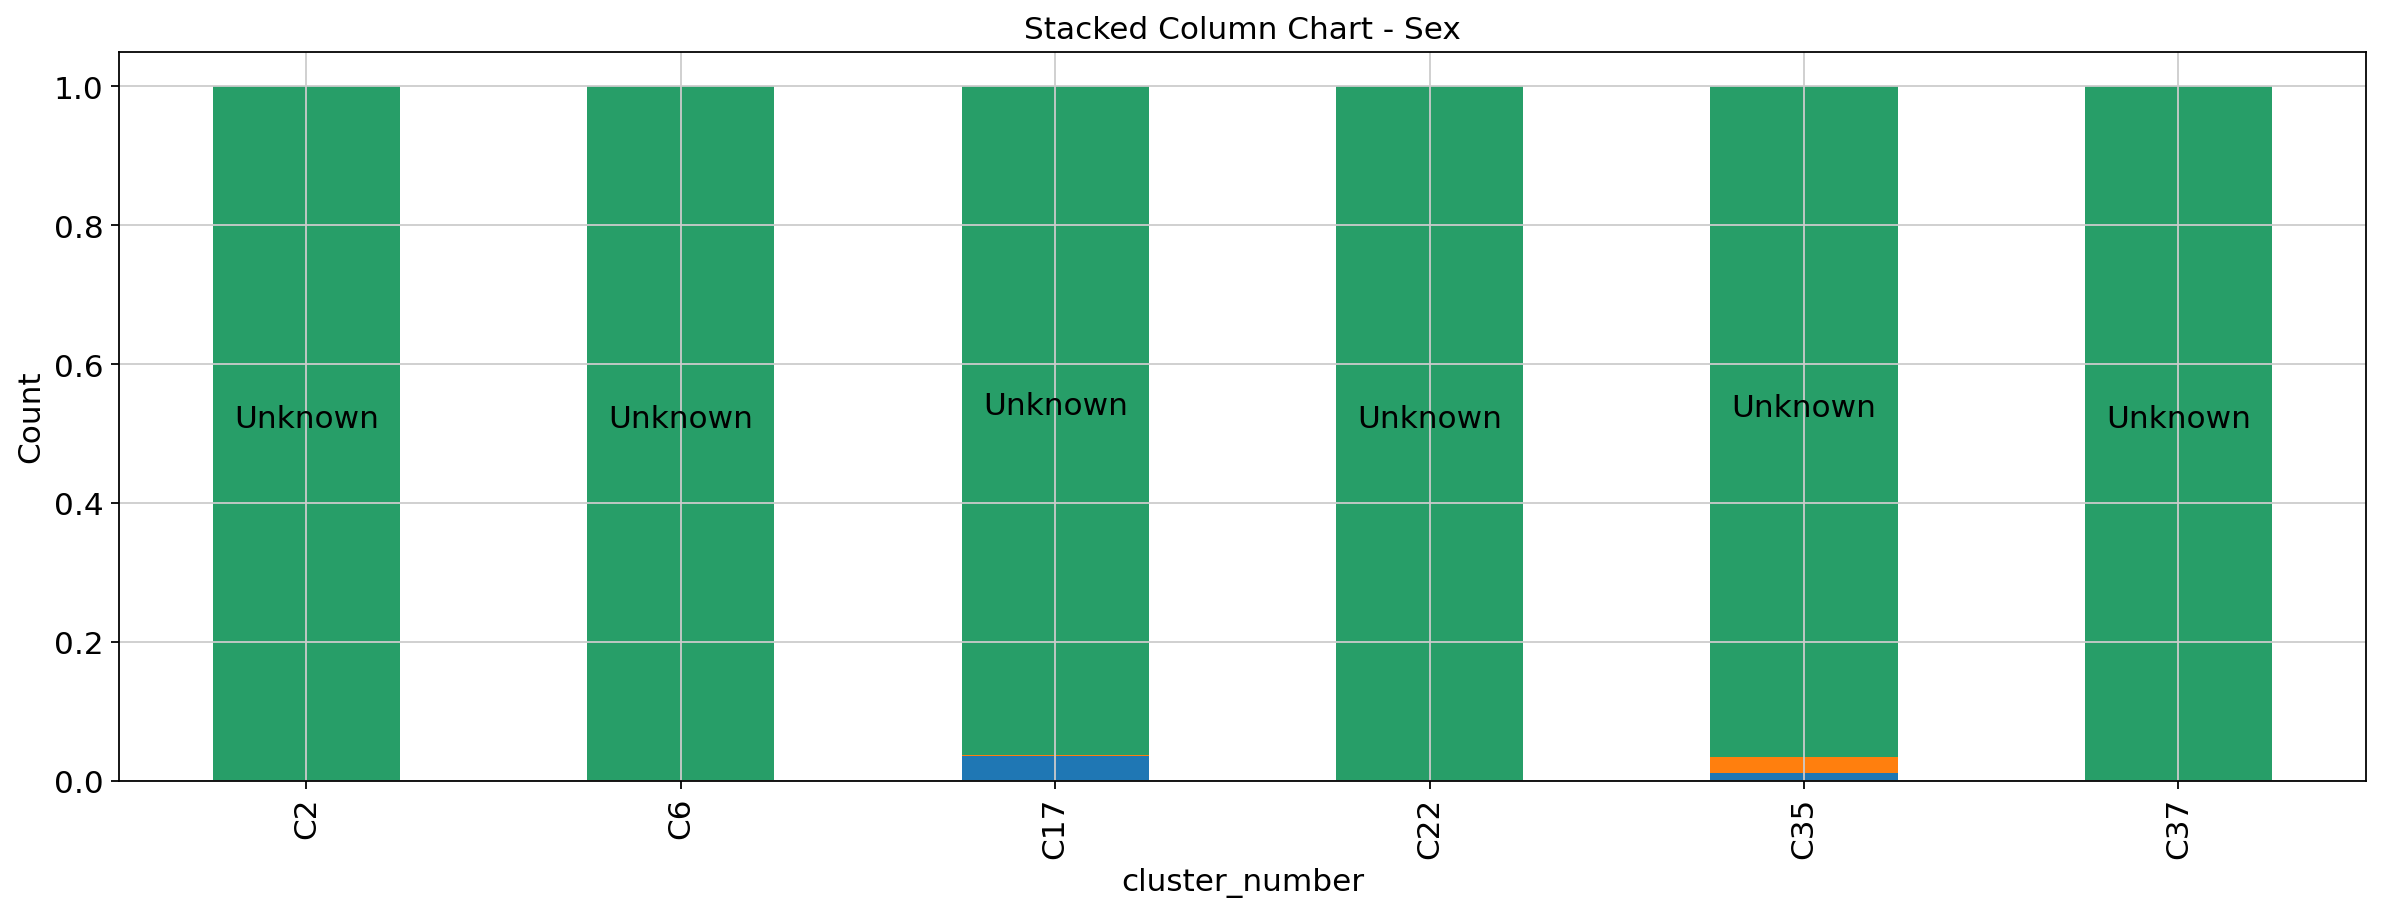

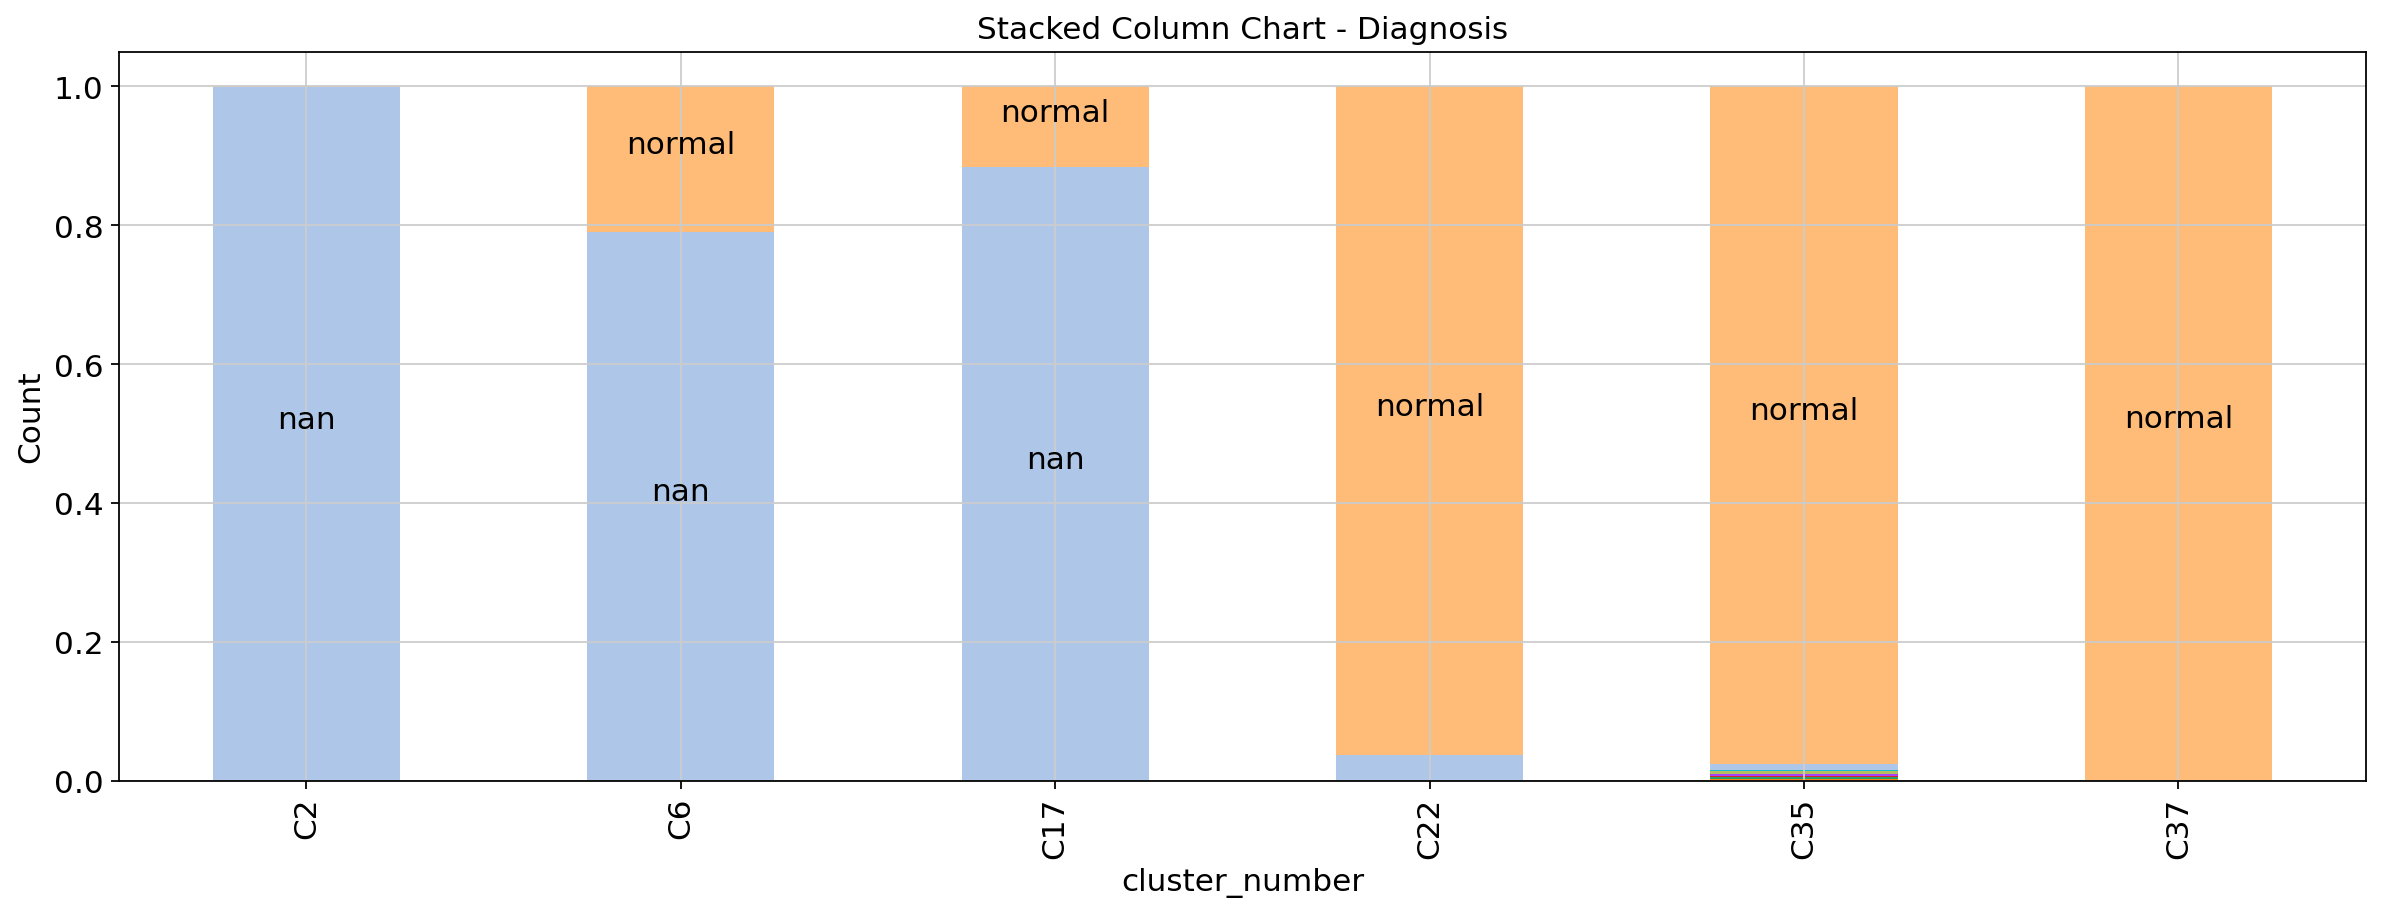

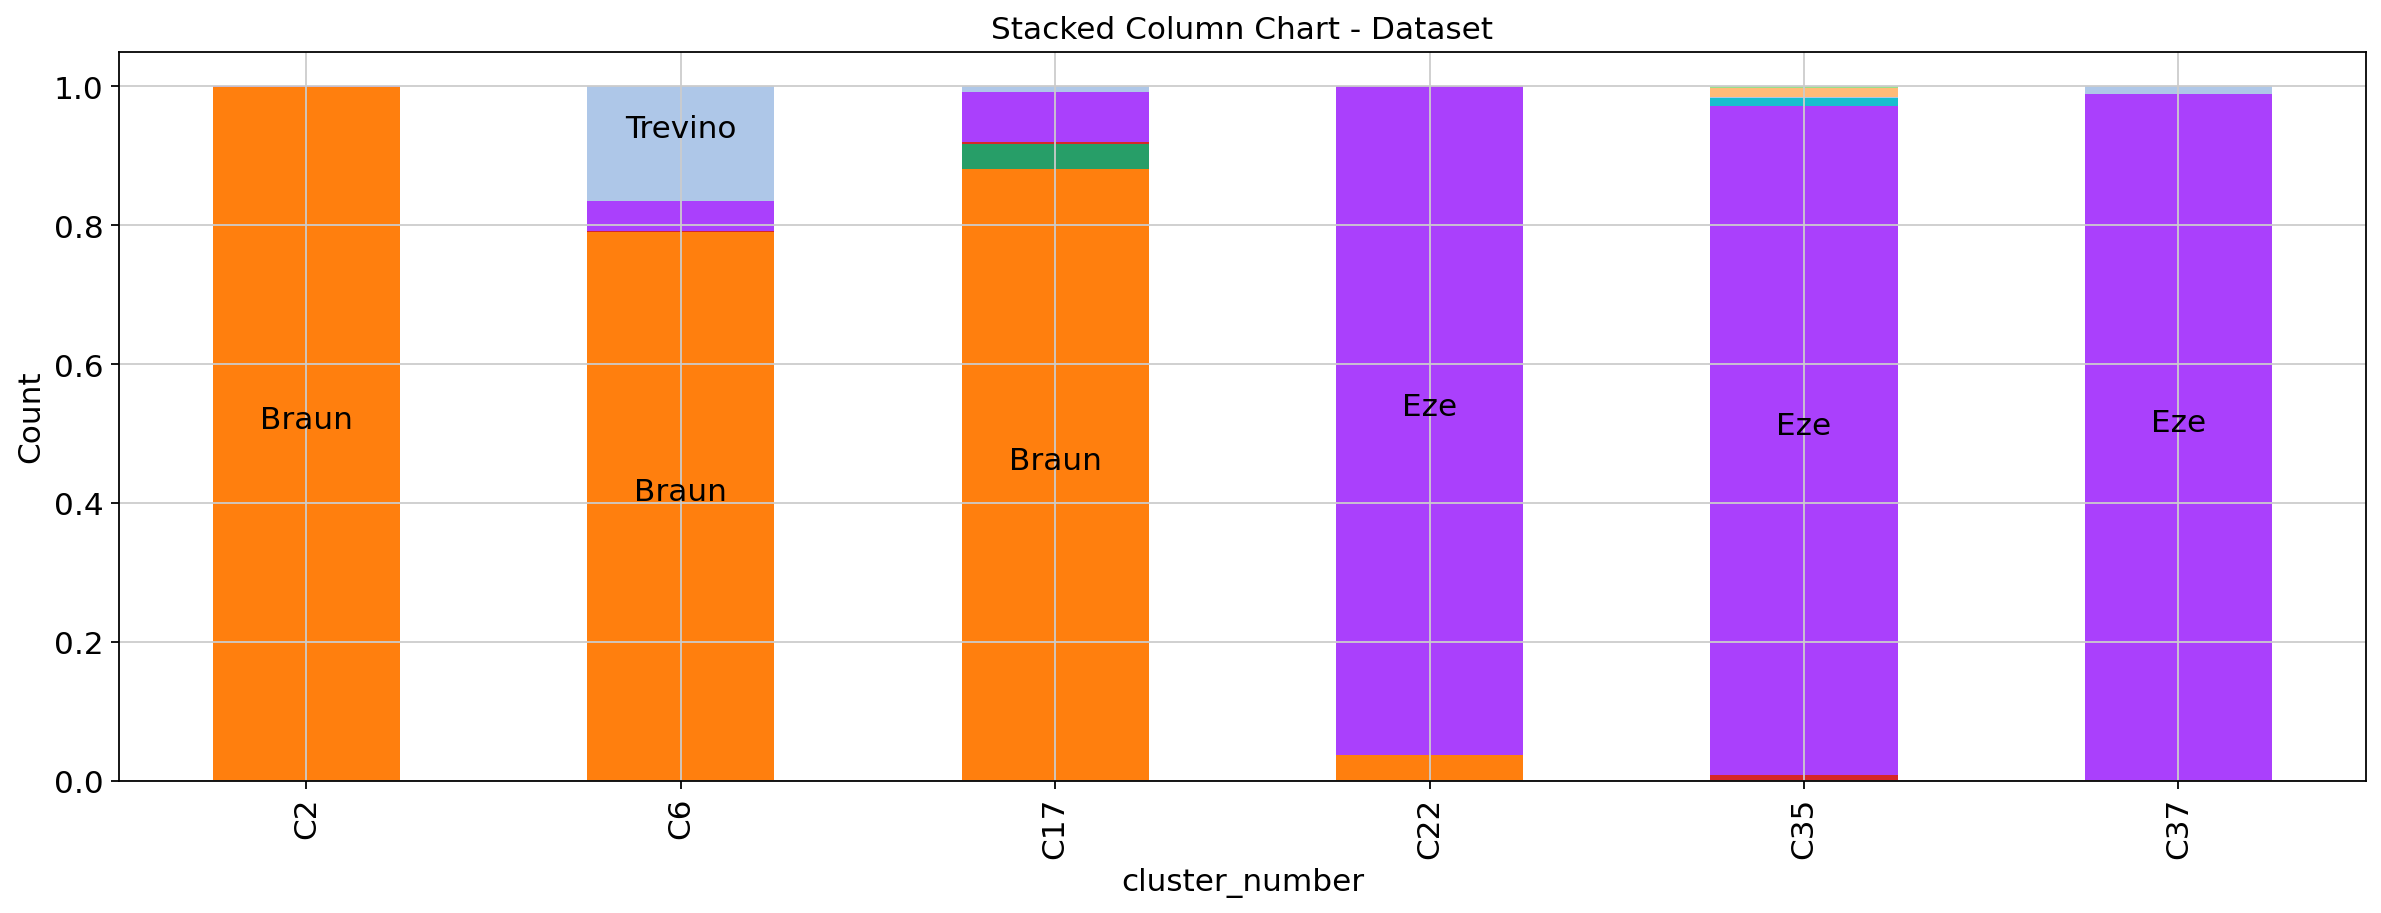

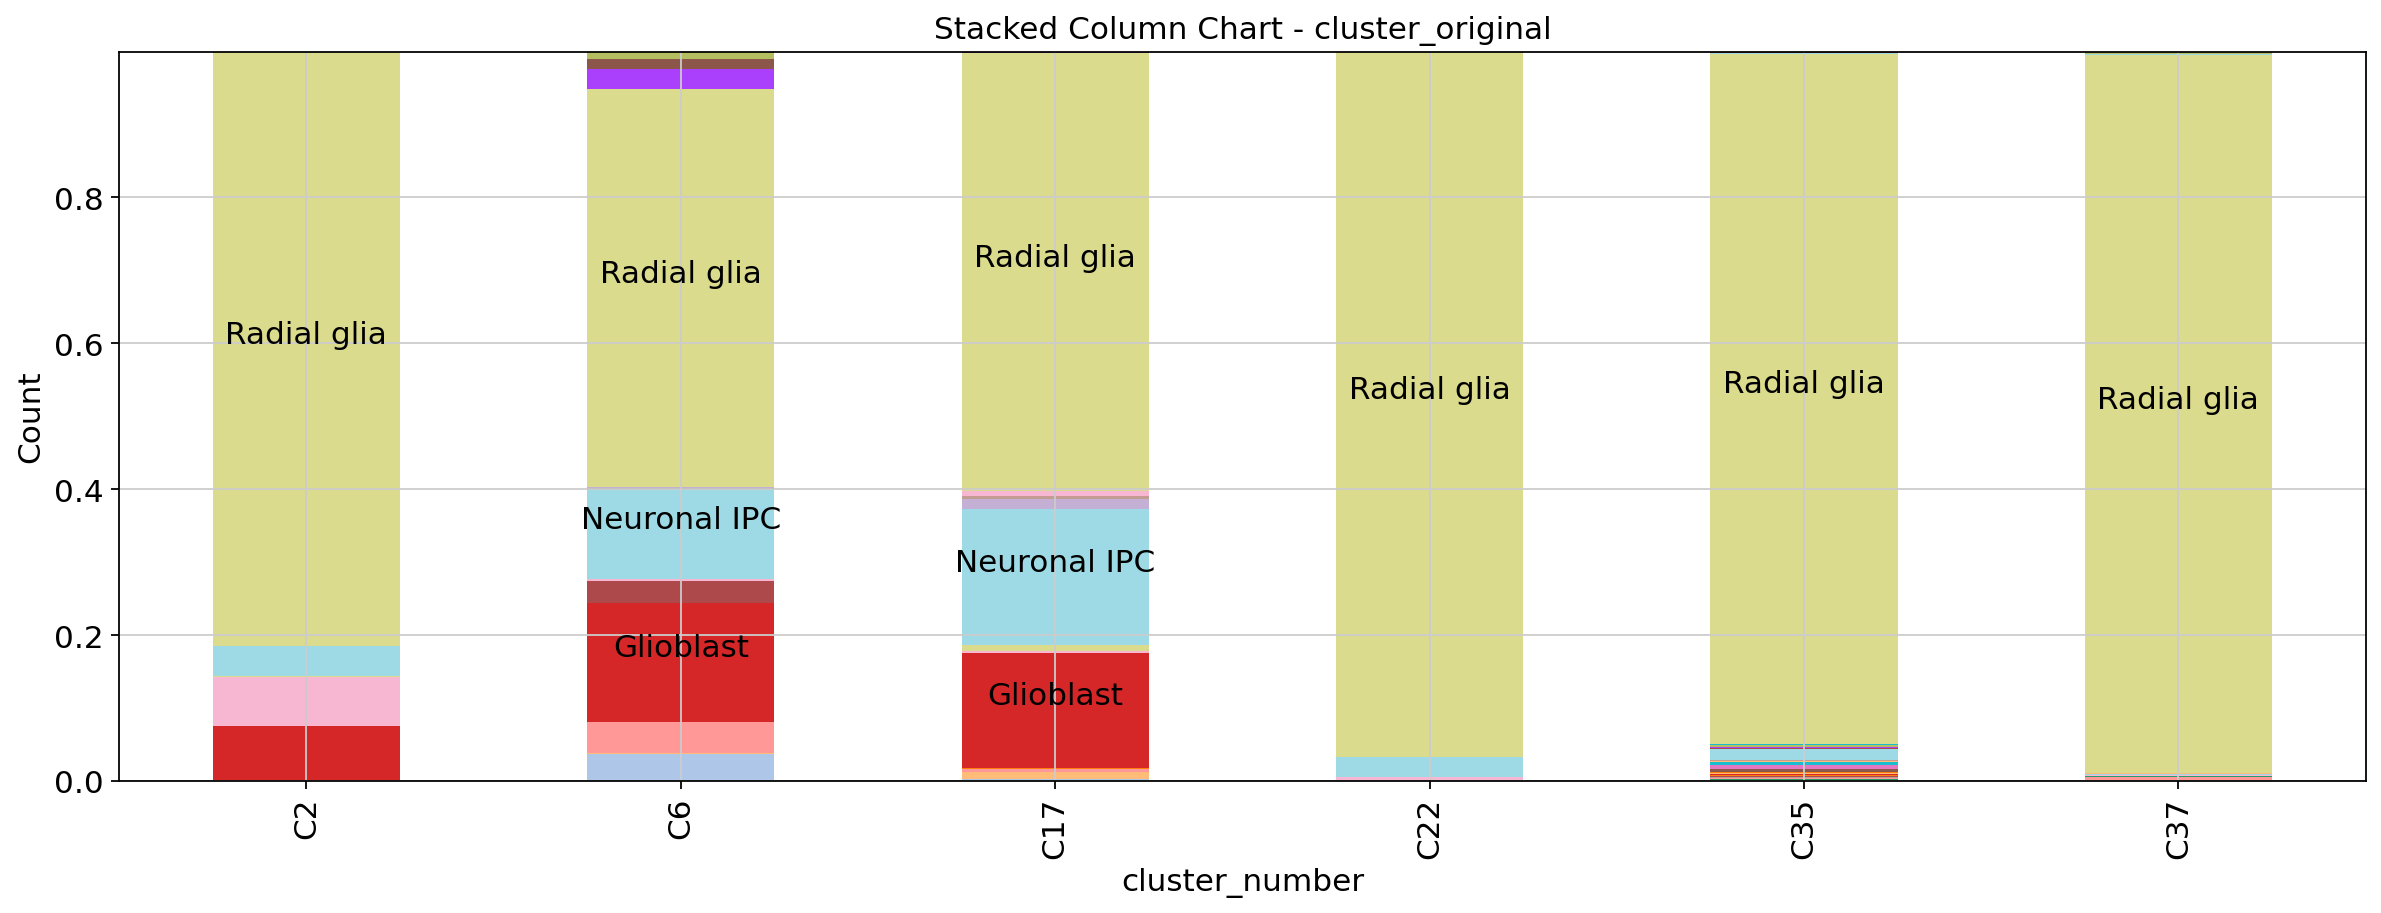

In [43]:
import matplotlib.pyplot as plt
df1 = adata.obs[['Brain_Region', 'Stage2', 'Sex', 'Diagnosis', 'Dataset', 'cluster_original', 'cluster_number']]

# Iterate over the columns and create individual stacked column charts
for column in df1.columns[:-1]:  # Exclude the 'cluster_number' column

    # Calculate the count of each unique value in the 'cluster_number' column
    grouped = df1.groupby(['cluster_number', column]).size().reset_index(name='count')

    # Pivot the DataFrame to have the 'cluster_number' column as the index and other columns as columns
    pivot_df = grouped.pivot(index='cluster_number', columns=column, values='count').fillna(0)

    # Calculate the percentage of each category within each 'cluster_number' group
    stacked_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

    # Plotting the stacked column chart
    ax = stacked_df.plot(kind='bar', stacked=True, figsize=(18, 6))

    # Set the title and axis labels
    plt.title(f"Stacked Column Chart - {column}")
    plt.xlabel('cluster_number')
    plt.ylabel('Count')

    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., ncol=2)

    # Add text labels on the stacked bars reflecting the bar group names
    for container, category in zip(ax.containers, stacked_df.columns):
        for rect in container.patches:
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            label = category if rect.get_height() >= 0.1 else ""  # Use the category name as the label if the proportion exceeds 0.1
            ax.text(x, y, label, ha='center', va='bottom')

    # Remove the legend
    ax.legend().remove()

    # Display the chart
    plt.show()


In [29]:
adata.obs[['Dataset', 'cluster_original']].value_counts()

Dataset           cluster_original
Braun             Radial glia         151943
Eze               Radial glia          53748
Braun             Glioblast            26258
                  Neuronal IPC         20791
                  Neuroblast            8078
                                       ...  
Eze               Immune                   1
Turecki           Ex_6_L4_6                1
Trevino           VLMC                     1
                  GluN1                    1
AllenMultiCortex  nan                      1
Length: 100, dtype: int64

In [45]:
filtered_data = adata[adata.obs['Dataset'] == 'Eze']

# Perform value counts on the filtered data
filtered_data.obs['cluster_original'].value_counts(normalize=True)

Radial glia     0.978019
Neuronal IPC    0.017578
Neuroblast      0.003858
Glioblast       0.000382
Neuron          0.000091
Vascular        0.000055
Immune          0.000018
Name: cluster_original, dtype: float64

In [48]:
filtered_data.obs['Age'].value_counts()

105.0    23080
140.0     9922
98.0      8042
91.0      5827
154.0     4594
84.0      2146
133.0     1345
Name: Age, dtype: int64

In [67]:
filtered_data = adata[adata.obs['Dataset'] == 'Braun']

# Perform value counts on the filtered data
filtered_data.obs['Brain_Region'].value_counts(normalize=True)

Forebrain              0.140008
Midbrain               0.131678
Cortex                 0.117709
Medulla                0.069058
Thalamus               0.067584
Brain                  0.064902
Striatum               0.064792
Cerebellum             0.060612
Subcortex              0.049499
Pons                   0.044149
Midbrain dorsal        0.036691
Hindbrain              0.029709
Diencephalon           0.022650
Hypothalamus           0.019284
Cortex frontal         0.009375
Cortical hem           0.008812
Hippocampus            0.008205
Caudate+Putamen        0.008012
Cortex temporal        0.007593
Telencephalon          0.007054
Cortex entorhinal      0.006597
Cortex parietal        0.006418
Cortex occipital       0.005865
Midbrain ventral       0.005836
Cortex hemisphere B    0.004854
Cortex hemisphere A    0.002855
Head                   0.000197
Name: Brain_Region, dtype: float64

In [37]:
filtered_data = adata[adata.obs['Dataset'] == 'Cameron']

# Perform value counts on the filtered data
filtered_data.obs['cluster_original'].value_counts(normalize=True)

RG-1      0.414478
CycPro    0.290199
RG-3      0.170404
RG-2      0.112748
InN-2     0.005125
InN-1     0.003203
IP        0.001281
InN-3     0.001281
InN-4     0.001281
Name: cluster_original, dtype: float64

In [36]:
filtered_data = adata[adata.obs['Dataset'] == 'Eze']

# Perform value counts on the filtered data
filtered_data.obs['Stage2'].value_counts(normalize=True)

Fetal (2nd trimester)    0.708585
Fetal (1st trimester)    0.291415
Name: Stage2, dtype: float64

In [35]:
filtered_data = adata[adata.obs['Dataset'] == 'Braun']

# Perform value counts on the filtered data
filtered_data.obs['cluster_original'].value_counts(normalize=True)

Radial glia     0.731617
Glioblast       0.126434
Neuronal IPC    0.100110
Neuroblast      0.038896
Neuron          0.002639
Neural crest    0.000091
Fibroblast      0.000072
Placodes        0.000067
Immune          0.000034
Oligo           0.000019
Vascular        0.000014
Erythrocyte     0.000005
Name: cluster_original, dtype: float64

In [42]:
filtered_data = adata[(adata.obs['cluster_number'] == 'C22') & (adata.obs['Stage2'] == 'Fetal (1st trimester)')]

# Perform value counts on the filtered data
filtered_data.obs['majority_voting'].value_counts(normalize=True)

Telencephalon radial glia      0.465020
Brain fibroblasts              0.296342
Midbrain radial glia           0.062512
Striatum radial glia           0.052140
Pons neuronal IPC              0.047803
Ventral midbrain neuron        0.027532
Diencephalon radial glia       0.018763
Forebrain radial glia          0.017820
Brain vascular cells           0.005374
Dorsal midbrain radial glia    0.001886
Pons radial glia               0.001791
Brain radial glia              0.000849
Cerebellum neuronal IPC        0.000849
Cerebellum radial glia         0.000754
Medulla radial glia            0.000471
Forebrain neuronal IPC         0.000094
Name: majority_voting, dtype: float64

In [49]:
marker_genes_dict = {
    'RG markers': ['VIM', 'HES1', 'PAX6', 'SOX2', 'ATP1A2', 'CLU', 'SPARC', 'SLC1A3', 'FABP7'],
    'IP markers': ['EOMES', 'PPP1R17', 'PENK', 'ELAVL4', 'HES6', 'NEUROD4', 'INSM1'],
    'oRG markers': ['HOPX', 'PTPRZ1', 'TNC', 'PTN', 'MOXD1', 'ITGB5', 'FAM107A', 'LIFR', 'NOG', 'IL6ST', 'SOX2', 'LGALS3BP', 'FAM107A'],
    'vRG markers': ['DDIT3', 'LDHA', 'CRYAB', 'PDGFD', 'PALLD', 'TAGLN2'],
}

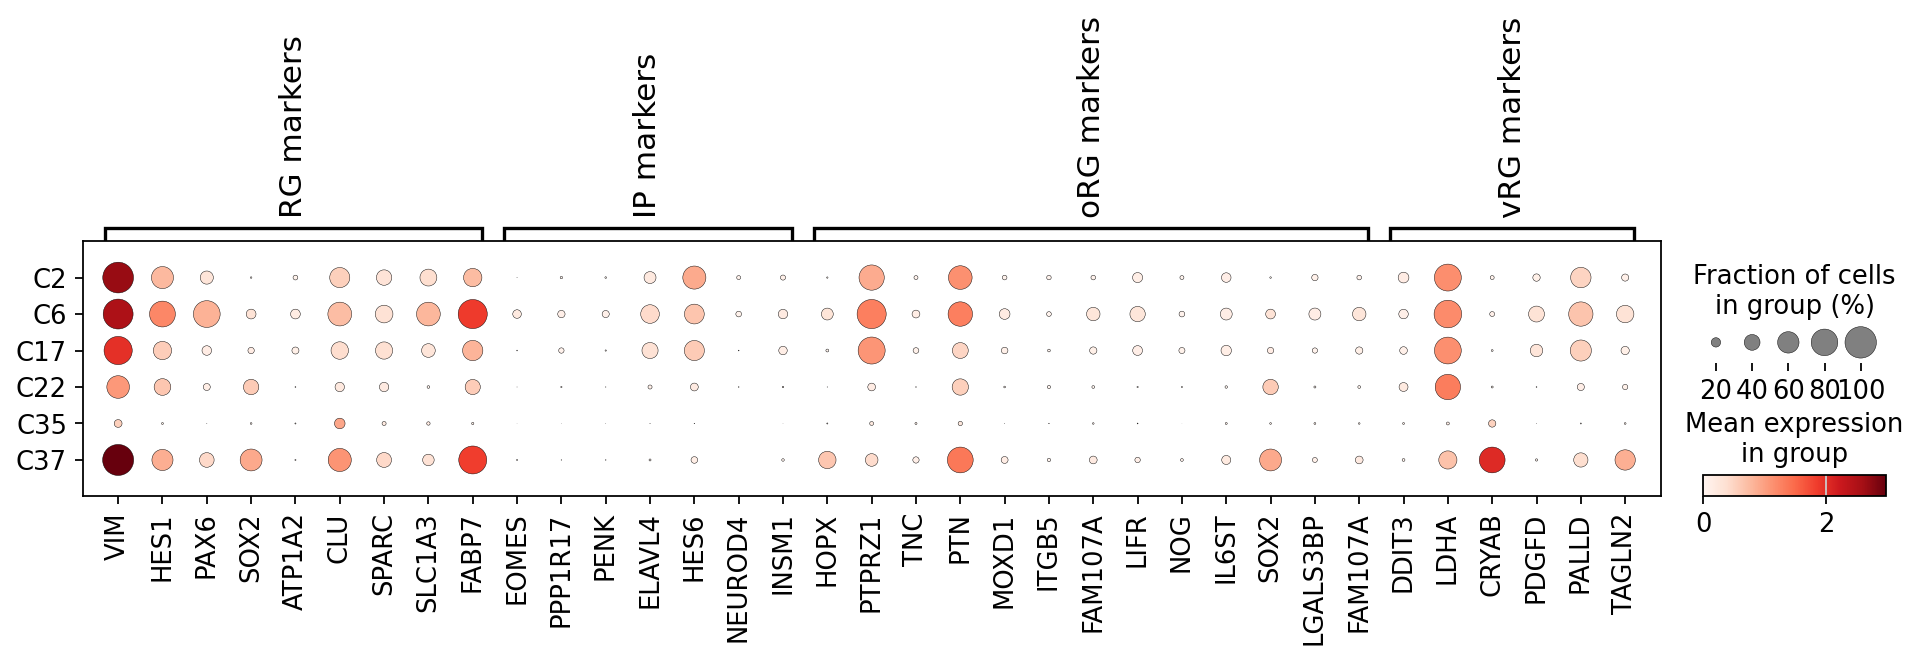

In [50]:
sc.pl.dotplot(adata, marker_genes_dict, 'cluster_number')

In [51]:
adata.write_h5ad("Data/Output_230816_subset.NeuralCrest_annotated_SYK.h5ad")

In [57]:
adata

AnnData object with n_obs × n_vars = 276111 × 49133
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI', 'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'DF_classification', 'cluster_original', 'cluster_main', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'cluster_number', 'cluster_raw', 'layer', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'Stage2', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    uns: 'Brain_Region_colors', 'Dataset_colors', 'Sex_colors', 'Stage2_colors', 'cluster_main_colors', 'cluster_number_colors', 'log1p', 'neighbors', 'umap', 'leiden', 'predicted_labels_colors', 'majority_voting_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts', 'logcounts', 'scaled'
    obsp: 'connectivities', 'distances'

In [61]:
filtered_adata = adata[adata.obs["cluster_number"] == "C22"].copy()

In [71]:
adata.obs.columns

Index(['batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'PMI',
       'Hemisphere', 'Library', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis',
       'DF_classification', 'cluster_original', 'cluster_main', 'n_genes',
       '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling',
       'cluster_number', 'cluster_raw', 'layer', 'L1', 'L2', 'L3', 'L4', 'L5',
       'L6', 'Stage2', 'predicted_labels', 'over_clustering',
       'majority_voting', 'conf_score'],
      dtype='object')

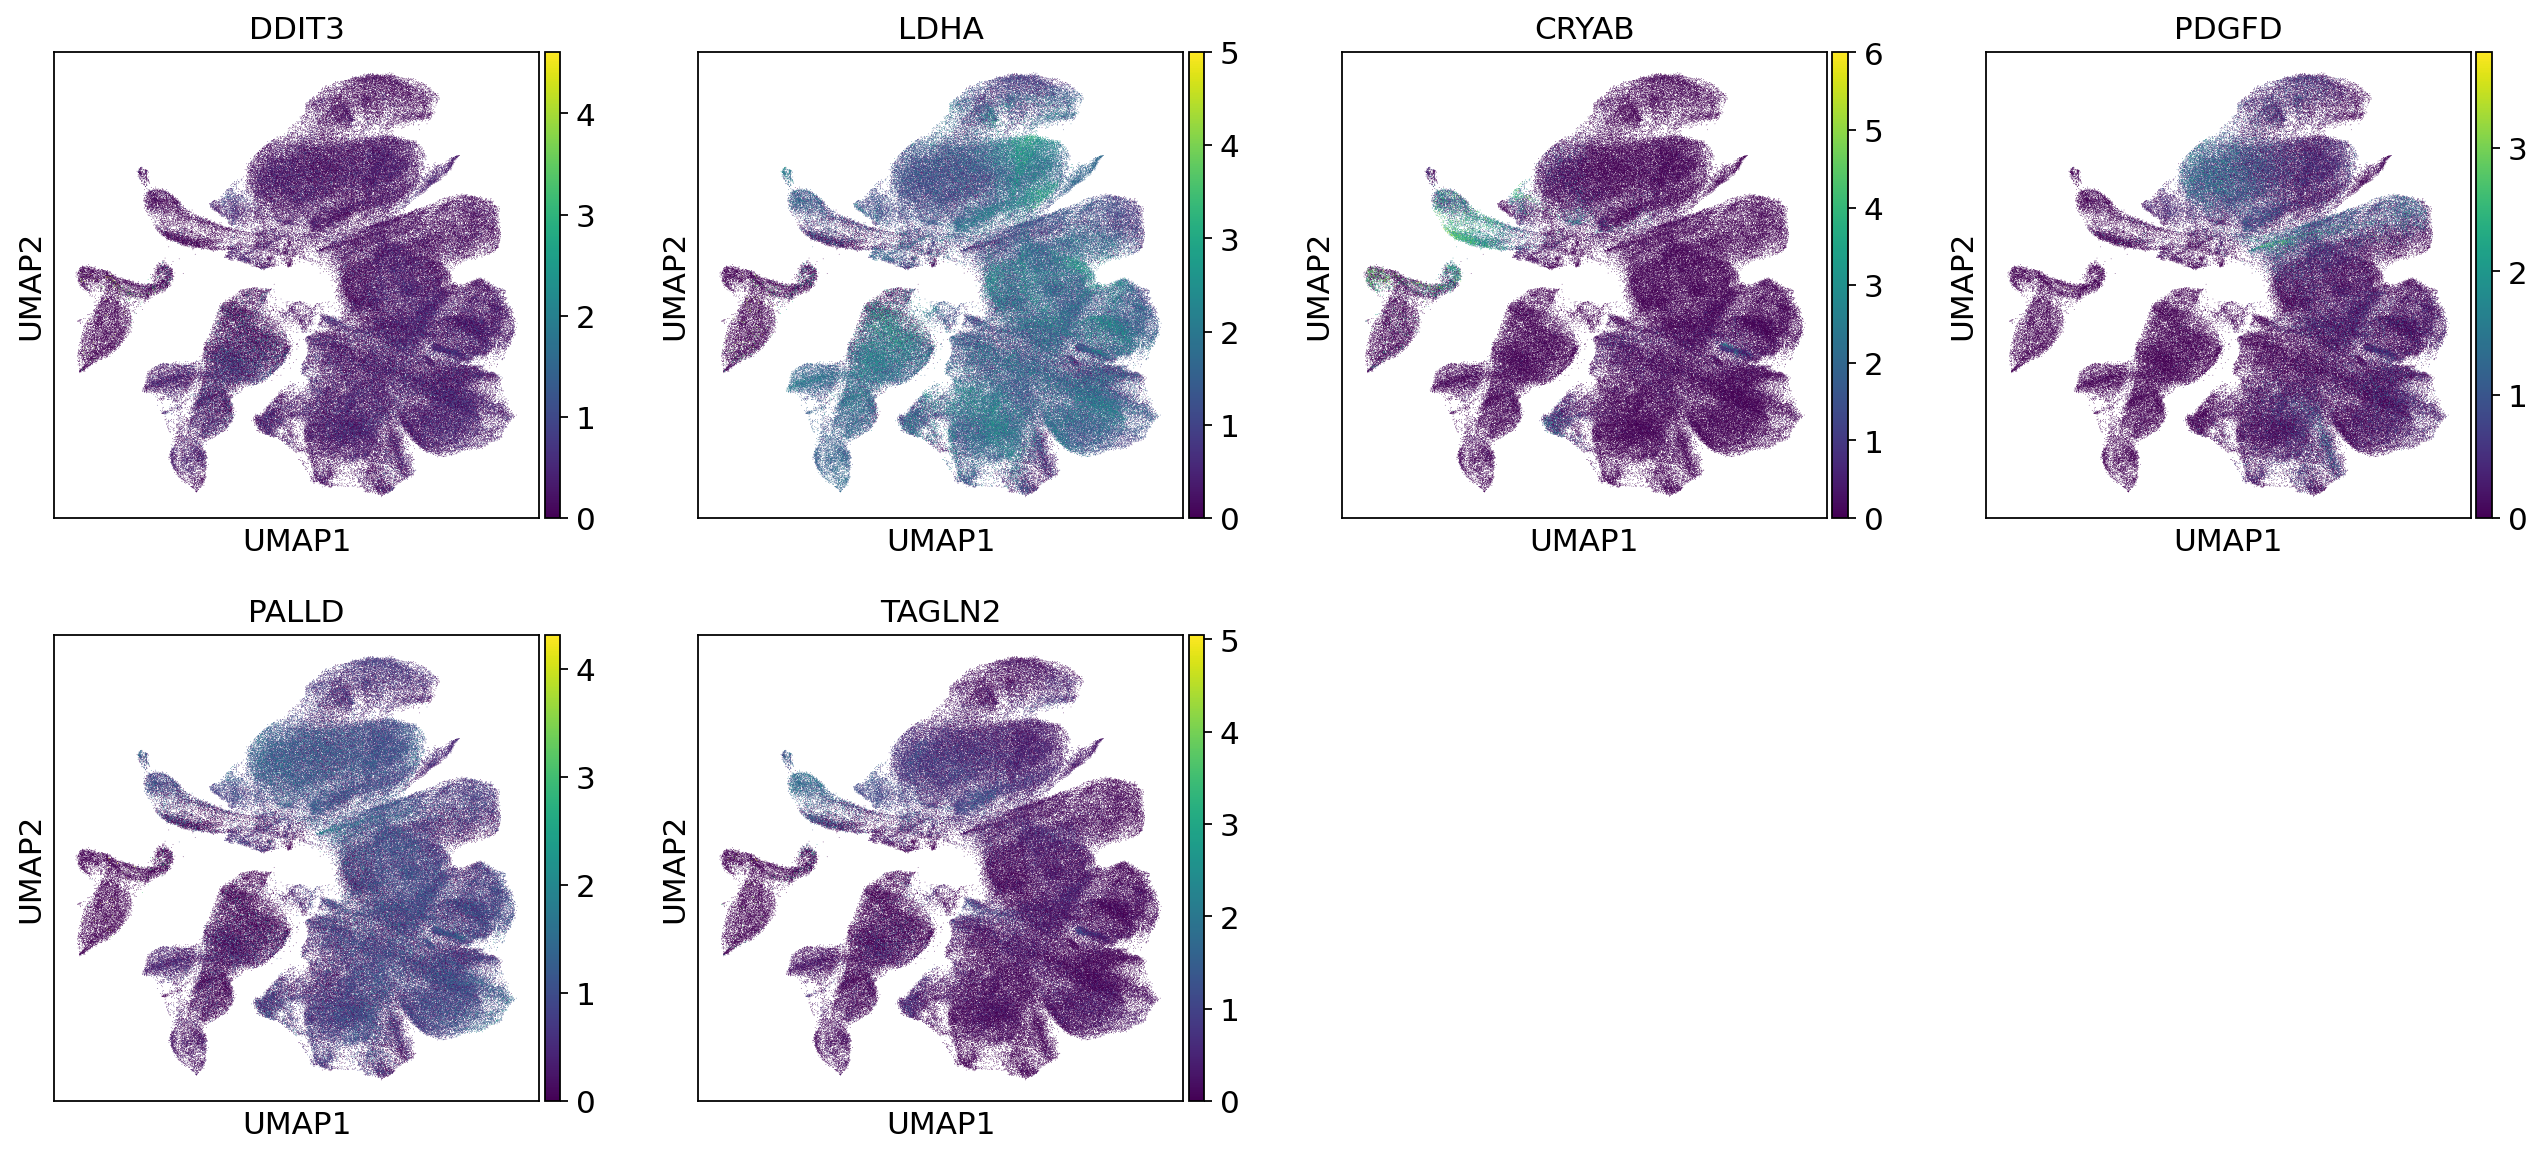

In [78]:
sc.pl.umap(adata, color = ["DDIT3", "LDHA", "CRYAB", "PDGFD", "PALLD", "TAGLN2"])

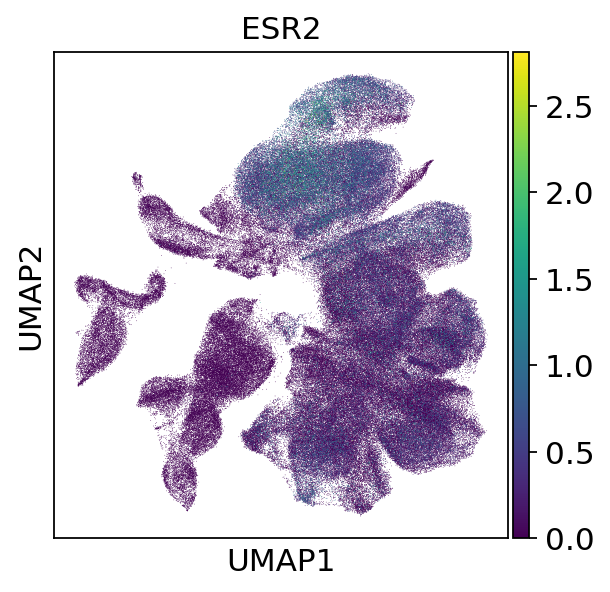

In [77]:
sc.pl.umap(adata, color = "ESR2")

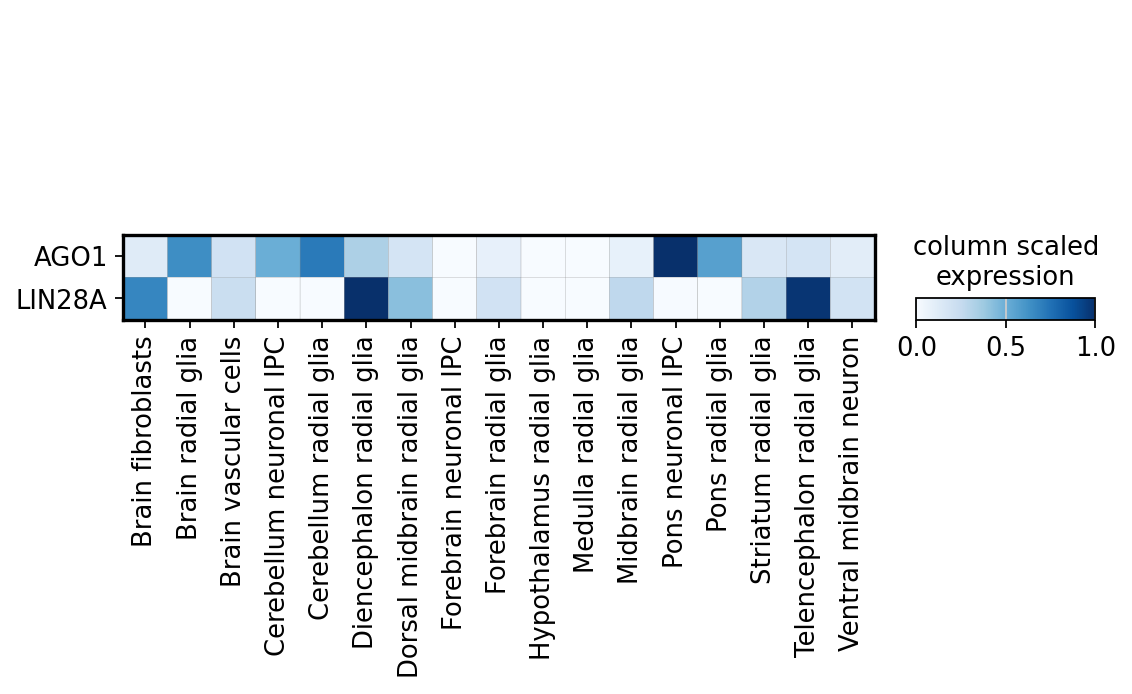

In [63]:
sc.pl.matrixplot(filtered_adata, ['AGO1', 'LIN28A'], groupby='majority_voting', cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression', swap_axes = True)

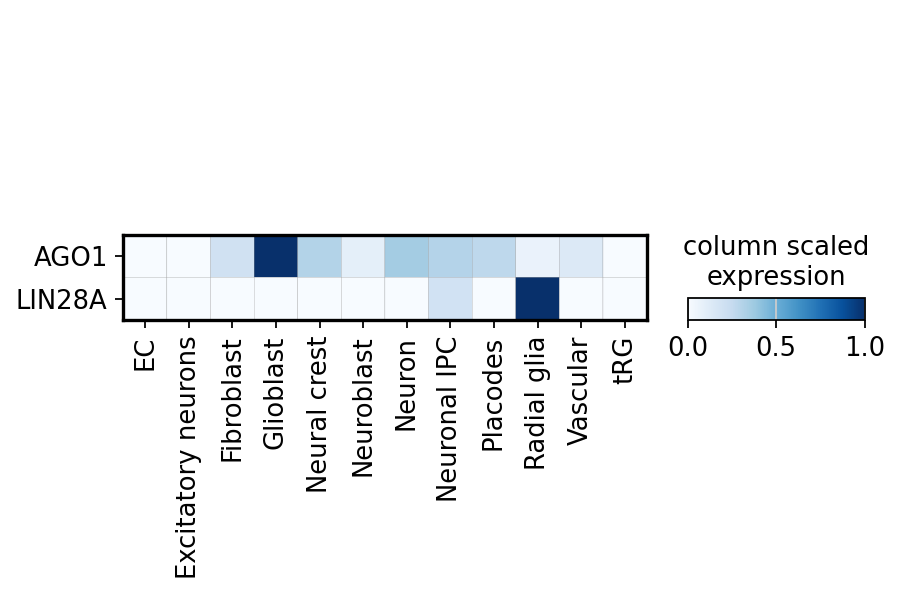

In [64]:
sc.pl.matrixplot(filtered_adata, ['AGO1', 'LIN28A'], groupby='cluster_original', cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression', swap_axes = True)

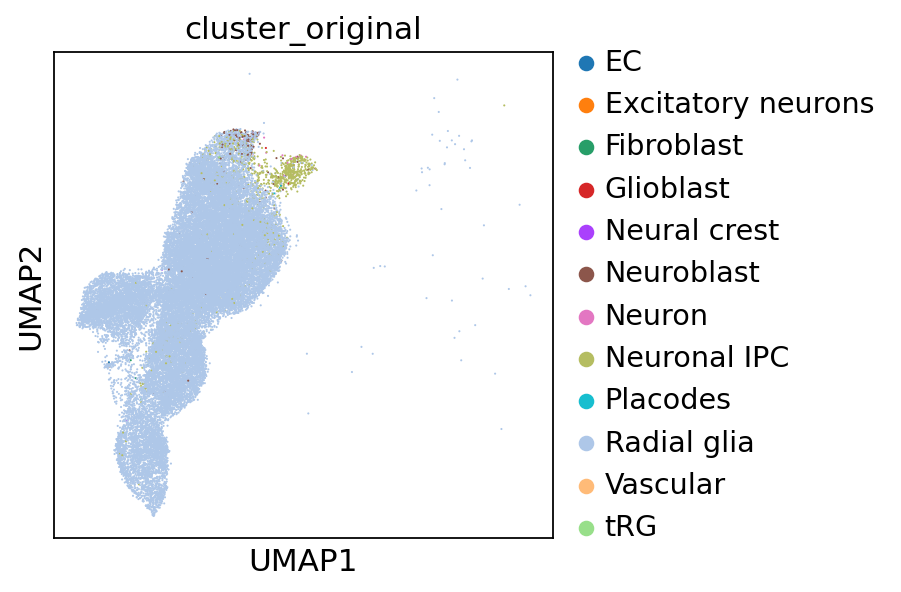

In [65]:
sc.pl.umap(filtered_adata, color = "cluster_original")